In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness, RandomZoom, RandomTranslation

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [2]:
# relative path to the dataset -> change as needed
PATH = "../gesture_dataset_sample/"

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [4]:
# pretty-print first element
print(json.dumps(annotations['like']['00ae4da4-9462-4804-ab99-5d2e409cd4b2'], indent=2))

{
  "bboxes": [
    [
      0.56004864,
      0.55650459,
      0.18327319,
      0.17768826
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.730763142633069,
        0.683576445015974
      ],
      [
        0.7041104627480214,
        0.6497426990629613
      ],
      [
        0.6622941789915147,
        0.6198364619279283
      ],
      [
        0.631479293229952,
        0.5958549780856107
      ],
      [
        0.6237001389824903,
        0.5695294644313559
      ],
      [
        0.6181716804176802,
        0.6237527867813881
      ],
      [
        0.5753533112326704,
        0.6527713001675327
      ],
      [
        0.5934691423311418,
        0.660826420087605
      ],
      [
        0.6107194047335265,
        0.6557881127689615
      ],
      [
        0.6203217131762268,
        0.6440693101816604
      ],
      [
        0.576915996432587,
        0.6750395627716688
      ],
      [
        0.5972215956543832,
        0.6796856893

## helper function to pre-process images (color channel conversion and resizing)

In [5]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [6]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

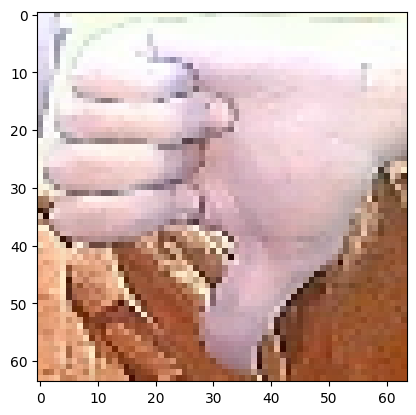

In [7]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [9]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


In [10]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
## #model.add(RandomBrightness(0.1))
## #model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\Leonie\Documents\Uni_Regensburg\SS2024\ITT\assignments\assignment-5-cnn-LeS-crypto\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [11]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1954 - loss: 1.7986 - val_accuracy: 0.1595 - val_loss: 1.8279 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2400 - loss: 1.7796 - val_accuracy: 0.1748 - val_loss: 1.7632 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2596 - loss: 1.7179 - val_accuracy: 0.3466 - val_loss: 1.6016 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4253 - loss: 1.4557 - val_accuracy: 0.5736 - val_loss: 1.0756 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5560 - loss: 1.1321 - val_accuracy: 0.7055 - val_loss: 0.7827 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6986 - loss: 0.8129 - val_accuracy: 0.8098 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7927 - loss: 0.

In [12]:
# let's have a look at our model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,428 (1.13 MB)

 Trainable params: 99,142 (387.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,286 (774.56 KB)

## Plot accuracy and loss of the training process

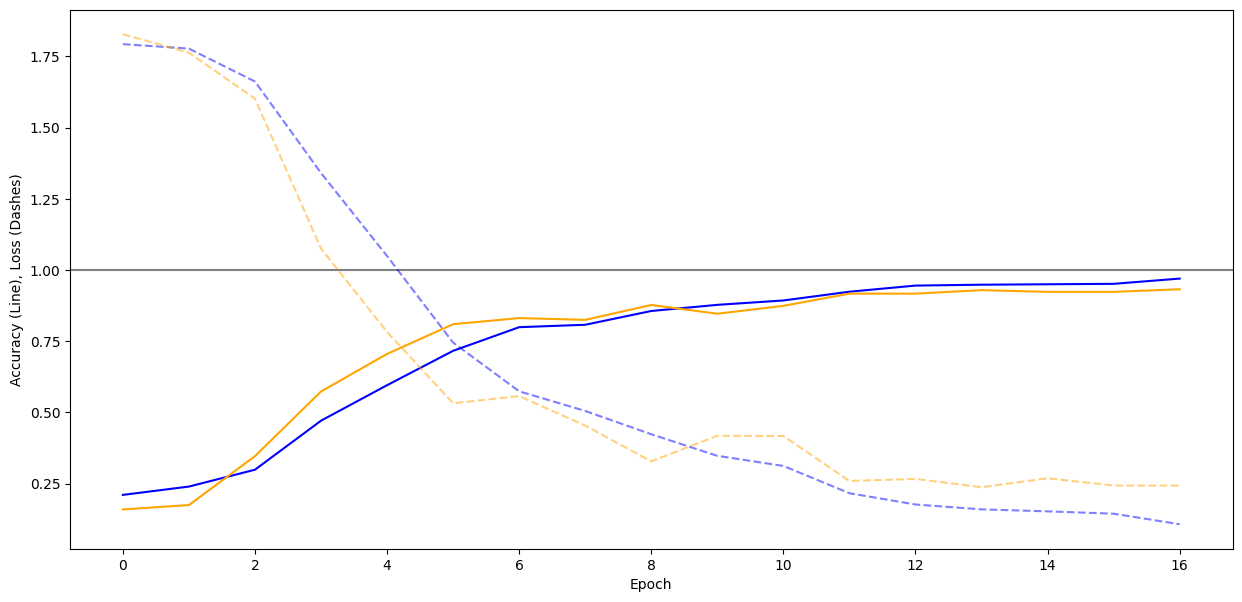

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [14]:
model.save('gesture_recognition.keras')
# model.save(model_file)

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
inference time = 0.27339625358581543 sec
probabilities [3 4 1 4 3 5 3 0 1 1 1 2 2 1 5 2 2 2 0 2 0 1 5 3 4 0 0 1 5 0 3 1 5 1 0 4 0
 5 0 1 2 1 4 0 3 2 4 5 4 5 1 3 1 3 5 1 1 4 0 0 0 5 4 5 4 1 4 2 1 2 2 3 1 1
 1 1 1 5 5 2 5 3 0 5 2 2 3 0 4 0 1 2 2 2 5 2 1 3 1 4 5 2 0 4 1 0 4 4 1 2 2
 2 1 1 1 4 2 2 1 2 4 1 4 2 0 1 2 2 3 1 5 5 3 0 0 3 2 0 1 2 3 0 0 0 2 4 4 3
 5 2 0 2 3 3 1 3 2 4 1 5 4 1 0 2 1 0 1 1 3 1 4 4 2 3 4 2 1 1 2 4 1 2 4 1 4
 1 4 5 4 1 3 1 5 4 2 2 3 5 4 3 4 3 4 4 5 0 4 4 0 0 1 0 0 2 4 4 5 2 1 4 1 1
 1 0 1 5 4 0 1 0 2 2 0 2 1 5 0 1 3 1 0 0 3 4 4 4 5 1 0 2 4 0 0 5 0 0 4 3 2
 5 4 5 5 0 4 0 0 1 0 1 0 4 3 1 2 1 2 3 3 0 1 3 3 2 4 2 0 5 1 2 3 3 1 2 1 3
 4 2 0 2 5 5 3 0 1 1 0 0 4 3 5 1 1 0 0 2 0 3 1 1 1 2 4 3 3 4]
accuracy_score = 0.9325153374233128


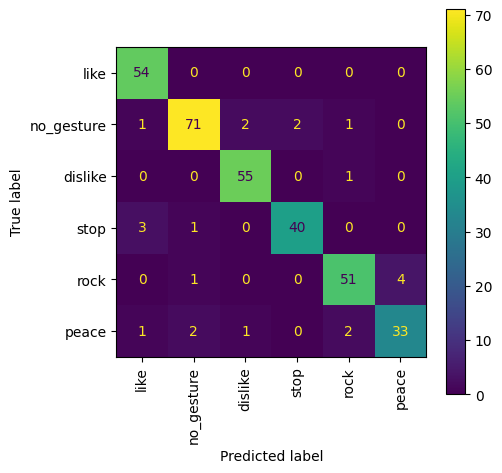

In [15]:
import time
# let the model make predictions for our training data

start = time.time() # measure time
y_predictions = model.predict(X_test)
end = time.time()
print("inference time =", (end-start), "sec") # time in seconds


# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# get the accuracy score
acc_score = accuracy_score(y_test, y_predictions)
print("accuracy_score =", acc_score)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(5, 5))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# 02 - Predict images

In [16]:
IMG_PATH = "../02-dataset/img"
ANOT_PATH = "../02-dataset/annot-leonie.json"

In [17]:
# load the custom annotations
custom_anots = dict()

with open(ANOT_PATH) as f:
        custom_anots = json.load(f)

In [18]:
# load images to predict
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# based on code above
i = 0
for filename in tqdm(os.listdir(IMG_PATH)):
    UID = filename # unique id just counts up
    img = cv2.imread(f"{IMG_PATH}/{filename}")

    try:
        annotation = custom_anots[str(UID)]
    except Exception as e:
        print(e)
        continue   

    for i, bbox in enumerate(annotation['bboxes']):
        x1 = int(bbox[0] * img.shape[1])
        y1 = int(bbox[1] * img.shape[0])
        w = int(bbox[2] * img.shape[1])
        h = int(bbox[3] * img.shape[0])
        x2 = x1 + w
        y2 = y1 + h

        crop = img[y1:y2, x1:x2]
        preprocessed = preprocess_image(crop)

        label = annotation['labels'][i]
        if label not in label_names:
            label_names.append(label)
        
        label_index = label_names.index(label)
        
        images.append(preprocessed)
        labels.append(label_index)

    i += 0 

  0%|          | 0/15 [00:00<?, ?it/s]

In [19]:
label_names

['dislike', 'no-gesture', 'like', 'peace', 'rock', 'stop']

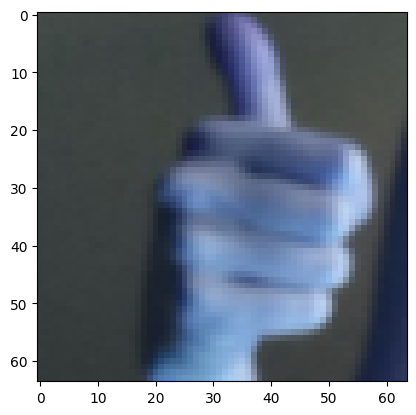

In [32]:
plt.imshow(random.sample(images, 1)[0])

In [33]:
# reshape
fresh = np.array(images).astype('float32')
fresh = fresh / 255.

reshaped = fresh.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

groundTruth = labels

print(reshaped.shape)
print(groundTruth)

(26, 64, 64, 3)
[0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 1, 3, 3, 3, 3, 4, 4, 1, 4, 1, 5, 1, 5, 5, 5, 1]


In [34]:
# make predictions on images (in 02-dataset/img)
predictions = model.predict(reshaped)
predictions = np.argmax(predictions, axis=1)

print("probabilities", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
probabilities [1 4 1 1 1 5 1 1 5 3 1 5 5 1 3 4 4 1 4 1 3 5 5 3 3 1]


In [35]:
# get the accuracy score
acc_score = accuracy_score(groundTruth, predictions)
print("accuracy_score =", acc_score)

accuracy_score = 0.4230769230769231


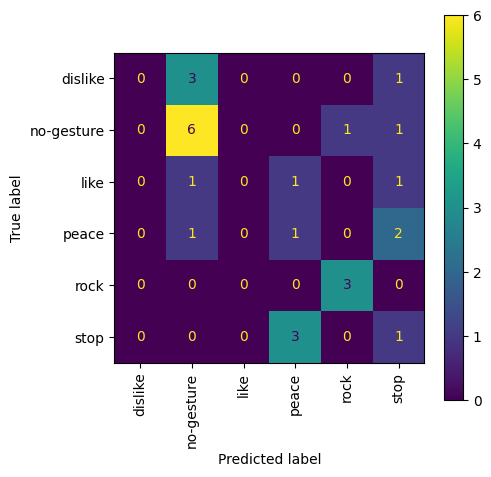

In [36]:
# create and plot confusion matrix
conf_matrix = confusion_matrix(groundTruth, predictions)

fig = plt.figure(figsize=(5, 5))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.show()